# Decision Trees

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from simple_cart.decision_tree import DecisionTree
from simple_cart.ensemble import Bagging, AdaBoost

np.random.seed(1)

## Regression Trees

In [2]:
#
# create dataset
#
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def sinusoidal(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(sinusoidal, 100, 0.2)
X_train = x_train[:, None]
X_test = np.linspace(0, 1, 100)[:, None]
y_test = sinusoidal(X_test)[:, 0]

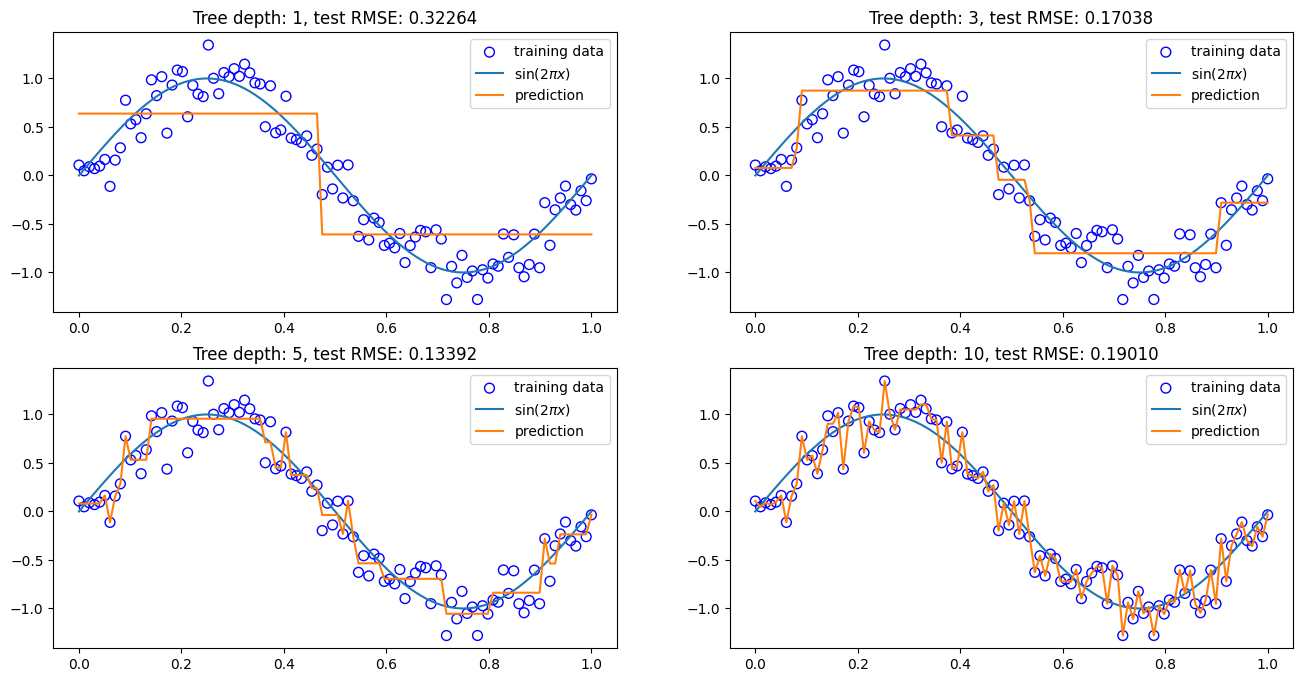

In [3]:
#
# tune model complexity through tree depth
#
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

for i, depth in enumerate([1, 3, 5, 10]):
    model = DecisionTree(criterion="squared_error", assign_leaf_node="mean", max_depth=depth)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(np.mean((preds - y_test)**2))

    row, col = divmod(i, 2)
    ax[row, col].set_title(f"Tree depth: {depth}, test RMSE: {rmse:.5f}")
    ax[row, col].scatter(X_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
    ax[row, col].plot(X_test, y_test, label="$\sin(2\pi x)$")
    ax[row, col].plot(X_test, preds, label="prediction")
    ax[row, col].legend()

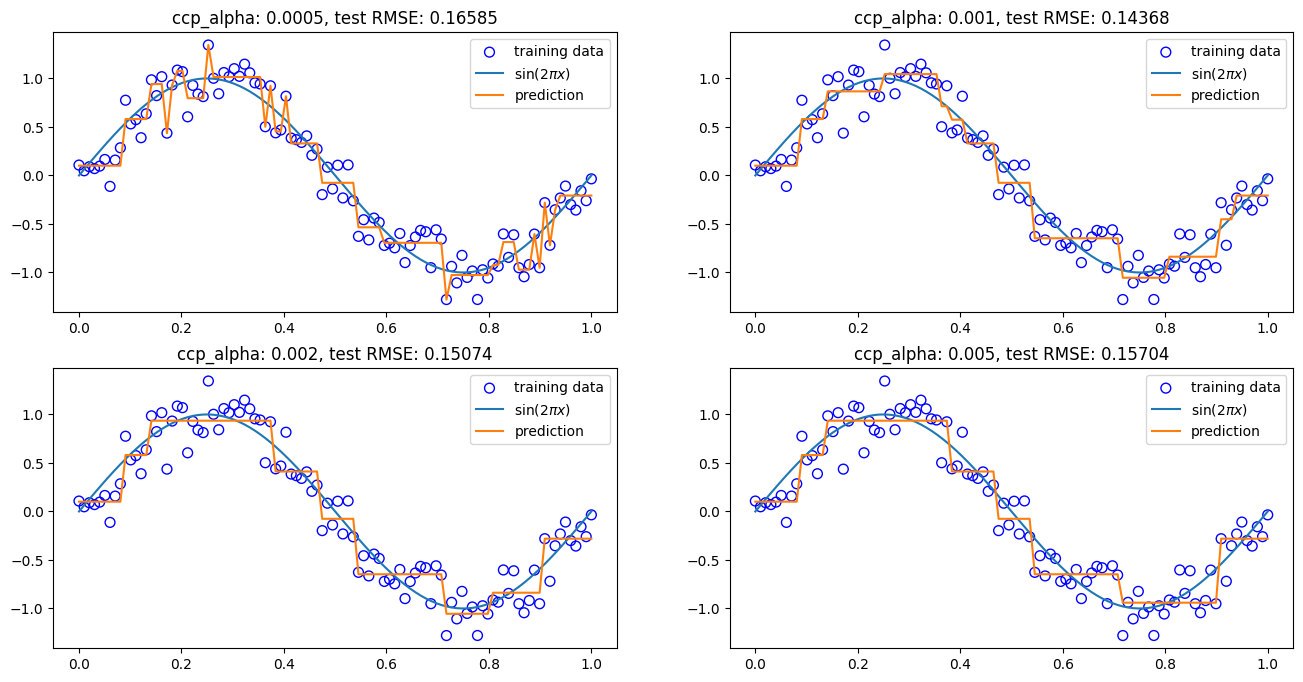

In [4]:
#
# tune model complexity through minimal cost-complexity pruning
#
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

for i, ccp_alpha in enumerate([0.0005, 0.001, 0.002, 0.005]):
    model = DecisionTree(criterion="squared_error", assign_leaf_node="mean", ccp_alpha=ccp_alpha)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(np.mean((preds - y_test)**2))

    row, col = divmod(i, 2)
    ax[row, col].set_title(f"ccp_alpha: {ccp_alpha}, test RMSE: {rmse:.5f}")
    ax[row, col].scatter(X_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
    ax[row, col].plot(X_test, y_test, label="$\sin(2\pi x)$")
    ax[row, col].plot(X_test, preds, label="prediction")
    ax[row, col].legend()

## Classification Trees

In [5]:
#
# load dataset
#
data = load_breast_cancer()
X, y = data.data, data.target
# convert labels to -1 and 1
y[y == 0] = -1
y[y == 1] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [6]:
#
# use different impurity criteria
#
clf_mis = DecisionTree(criterion="misclassification_rate", assign_leaf_node="most_common")
clf_mis.fit(X_train, y_train)
pred = clf_mis.predict(X_test)
print("Accuracy (criterion: misclassification rate):", np.mean(pred == y_test).item())

clf_gini = DecisionTree(criterion="gini", assign_leaf_node="most_common")
clf_gini.fit(X_train, y_train)
pred = clf_gini.predict(X_test)
print("Accuracy (criterion: Gini index):", np.mean(pred == y_test).item())

clf_ent = DecisionTree(criterion="entropy", assign_leaf_node="most_common")
clf_ent.fit(X_train, y_train)
pred = clf_ent.predict(X_test)
print("Accuracy (criterion: entropy):", np.mean(pred == y_test).item())

Accuracy (criterion: misclassification rate): 0.868421052631579
Accuracy (criterion: Gini index): 0.9122807017543859
Accuracy (criterion: entropy): 0.9385964912280702


In [7]:
#
# prune tree to limit overfitting, we can also specify min_samples_split stopping criterion
#
clf_gini_pruned = DecisionTree(criterion="gini", assign_leaf_node="most_common", min_samples_split=5, ccp_alpha=0.01)
clf_gini_pruned.fit(X_train, y_train)
pred = clf_gini_pruned.predict(X_test)
print("Accuracy (pruned, criterion: Gini index):", np.mean(pred == y_test).item())

Accuracy (pruned, criterion: Gini index): 0.9385964912280702


In [8]:
clf_gini.print_tree()

pred=1, impurity=0.46806, samples=455.0, x[22] < 106.05000000000001 ?
	yes -> pred=1, impurity=0.06421, samples=271.0, x[27] < 0.15889999999999999 ?
		yes -> pred=1, impurity=0.02973, samples=265.0, x[27] < 0.13505 ?
			yes -> pred=1, impurity=0.00784, samples=254.0, x[10] < 0.6431 ?
				yes -> pred=1, impurity=0.00000, samples=251.0
				no  -> pred=1, impurity=0.44444, samples=3.0, x[0] < 12.265 ?
					yes -> pred=-1, impurity=0.00000, samples=1.0
					no  -> pred=1, impurity=0.00000, samples=2.0
			no  -> pred=1, impurity=0.39669, samples=11.0, x[1] < 20.84 ?
				yes -> pred=1, impurity=0.00000, samples=8.0
				no  -> pred=-1, impurity=0.00000, samples=3.0
		no  -> pred=-1, impurity=0.27778, samples=6.0, x[1] < 16.22 ?
			yes -> pred=1, impurity=0.00000, samples=1.0
			no  -> pred=-1, impurity=0.00000, samples=5.0
	no  -> pred=-1, impurity=0.21875, samples=184.0, x[21] < 20.645 ?
		yes -> pred=1, impurity=0.38781, samples=19.0, x[20] < 17.740000000000002 ?
			yes -> pred=1, impurity=

In [9]:
clf_gini_pruned.print_tree()

pred=1, impurity=0.46806, samples=455.0, x[22] < 106.05000000000001 ?
	yes -> pred=1, impurity=0.06421, samples=271.0, x[27] < 0.15889999999999999 ?
		yes -> pred=1, impurity=0.02973, samples=265.0
		no  -> pred=-1, impurity=0.27778, samples=6.0
	no  -> pred=-1, impurity=0.21875, samples=184.0, x[21] < 20.645 ?
		yes -> pred=1, impurity=0.38781, samples=19.0, x[20] < 17.740000000000002 ?
			yes -> pred=1, impurity=0.00000, samples=13.0
			no  -> pred=-1, impurity=0.27778, samples=6.0
		no  -> pred=-1, impurity=0.10314, samples=165.0, x[7] < 0.048865 ?
			yes -> pred=-1, impurity=0.49383, samples=18.0, x[15] < 0.017175 ?
				yes -> pred=-1, impurity=0.00000, samples=10.0
				no  -> pred=1, impurity=0.00000, samples=8.0
			no  -> pred=-1, impurity=0.01351, samples=147.0


# Ensembles

In [10]:
#
# load classification dataset
#
data = load_breast_cancer()
X, y = data.data, data.target
# convert labels to -1 and 1
y[y == 0] = -1
y[y == 1] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Bagging (bootstrap aggregation)

Accuracy on the test set: 0.93


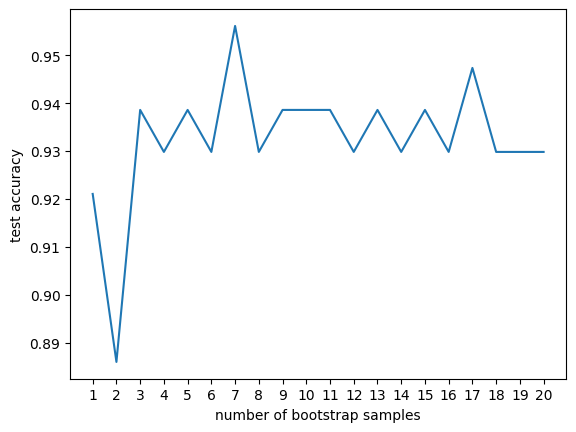

In [11]:
M = 20
base = DecisionTree(criterion="gini", assign_leaf_node="most_common")
model = Bagging(base, M=M)
model.fit(X_train, y_train)
preds = model.predict(X_test)

accuracy = np.mean(preds == y_test).item()
print(f"Accuracy on the test set: {accuracy:.2f}")

acc = []
for m in range(M):
    y = sum([clf_m.predict(X_test) for clf_m in model.clfs[:m + 1]])
    accuracy = np.mean(np.sign(y) == y_test).item()
    acc.append(accuracy)

plt.plot(np.arange(1, M+1), acc)
plt.xticks(np.arange(1, M+1))
plt.xlabel("number of bootstrap samples")
plt.ylabel("test accuracy");

By limiting the number of features that are considered at each split in the trees of the bootstrap aggregation, we obtain a **random forest**.

Accuracy on the test set: 0.95


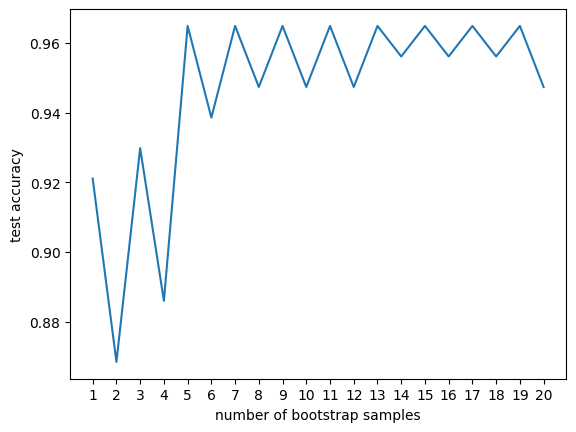

In [12]:
M = 20
base = DecisionTree(criterion="gini", assign_leaf_node="most_common", max_features="sqrt")
model = Bagging(base, M=M)
model.fit(X_train, y_train)
preds = model.predict(X_test)

accuracy = np.mean(preds == y_test).item()
print(f"Accuracy on the test set: {accuracy:.2f}")

acc = []
for m in range(M):
    y = sum([clf_m.predict(X_test) for clf_m in model.clfs[:m + 1]])
    accuracy = np.mean(np.sign(y) == y_test).item()
    acc.append(accuracy)

plt.plot(np.arange(1, M+1), acc)
plt.xticks(np.arange(1, M+1))
plt.xlabel("number of bootstrap samples")
plt.ylabel("test accuracy");

## Boosting

In [13]:
# AdaBoost.M1 model
M = 20
base_clf = DecisionTree(max_depth=1, criterion="misclassification_rate", assign_leaf_node="most_common")
model = AdaBoost(base_clf=base_clf, M=M)
model.fit(X_train, y_train)
preds = model.predict(X_test)

accuracy = np.mean(preds == y_test).item()
print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.95


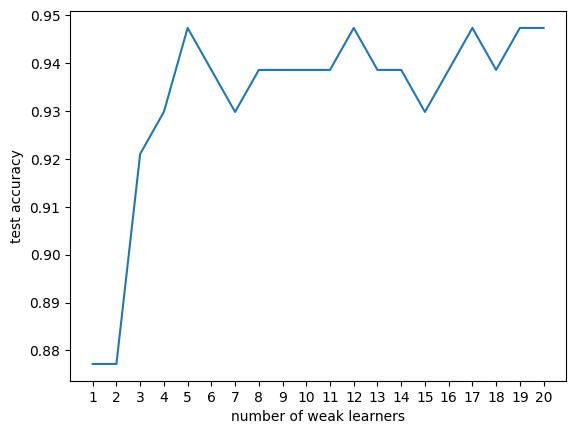

In [14]:
acc = []
for m in range(M):
    y = sum(
        [
            alpha_m * clf_m.predict(X_test)
            for alpha_m, clf_m in zip(model.alphas[:m + 1], model.clfs[:m + 1])
        ]
    )
    accuracy = np.mean(np.sign(y) == y_test).item()
    acc.append(accuracy)

plt.plot(np.arange(1, M+1), acc)
plt.xticks(np.arange(1, M+1))
plt.xlabel("number of weak learners")
plt.ylabel("test accuracy");